# Part 2: Complete ML example with low-level APIs

In this part of the tutorial, we will train a simple parametric model on the MNIST dataset from scratch.

For educational purposes, we will implement the model, its appropriate loss function, gradient descent, and a simple training loop using low-level tensorflow functions from scratch. 
<bl>
In practice, you will often use higher-level APIs that do much of this work for you and add further functionality. 
But to understand what these high-level APIs do in the background, we will first need to get our hands dirty with low-level API and the concepts introduced in part 1.

In [11]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np

### Data

In [12]:
data = input_data.read_data_sets("data/MNIST/", one_hot=True)
# Note: Currently, tf prints some annoying warnings for this dataset, just run this cell twice.

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [13]:
print("The dataset is already split into training, validation and testing:")
print("Train:\t{}".format(len(data.train.labels)))
print("Val:\t{}".format(len(data.validation.labels)))
print("Test:\t{}".format(len(data.test.labels)))

The dataset is already split into training, validation and testing:
Train:	55000
Val:	5000
Test:	10000


In [14]:
# We can extract *random* batches from the training data as follows
batch_inputs, batch_targets = data.train.next_batch(batch_size=42)
print("inputs shape: {}".format(batch_inputs.shape))
print("targets shape: {}".format(batch_targets.shape))

inputs shape: (42, 784)
targets shape: (42, 10)


target: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


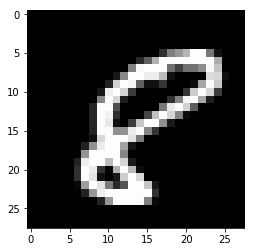

In [15]:
# Lets plot a random sample input and target from the batch.
idx = 0  
plt.figure()
plt.imshow(np.reshape(batch_inputs[idx], [28, 28]), cmap='gray')
print("target: {}".format(batch_targets[idx]))

### Model

In [16]:
class LinearModel():
    """ 
    Example class for linear model.
    Creates the model parameters (tf.Variable) when class is instantiated. 
    Builds the graph when the instance is applied to an input.
    """
    def __init__(self, dim_in, dim_out):
        self.weights = tf.Variable(initial_value=tf.random_normal([dim_in, dim_out], stddev=0.1), name="weights")
        self.biases = tf.Variable(initial_value=tf.zeros([dim_out]), name="biases")
        
    def __call__(self, inputs):
        outputs = tf.add(self.biases, tf.matmul(inputs, self.weights))
        return outputs

MyModel = LinearModel

### Model

In [17]:
# images have 28*28 pixels. Targets 0-9 (categorical variable with 10 possible values)
dim_in, dim_out = 784, 10
batch_size = 128

In [18]:
tf.reset_default_graph()  # Might be helpful, if you rebuild your model.

labels = tf.placeholder(shape=[batch_size, dim_out], dtype=tf.int32, name="targets")
inputs = tf.placeholder(shape=[batch_size, dim_in], dtype=tf.float32, name="inputs")

model = MyModel(dim_in=dim_in, dim_out=dim_out)
outputs = model(inputs) 

### Loss

**Task 1 - Implement loss function**: Our model simply calculates a linear transformation of the inputs. 
The outputs can be interpreted as "logits", which are the logarithms of the unnormalized probabilities of our K=10 classes. 
<br>
One common approach in machine learning is to maximize the likelihood (maximum likelihood), which is the log-probability of the observed data under the model:
<br>
$\hat{\theta} = \text{argmax}_{\theta} \sum_{n=1}^{N} \log p_{\theta}(\mathbf{y}^{(n)} ~|~ \mathbf{x}^{(n)})$, where $\theta$ are the model parameters, $\mathbf{y}$ are labels, $\mathbf{x}$ are inputs and N is the number of samples in the dataset. 
When training with *stochastic* gradient descent, we approximate the sum using a mini-batch of samples instead of the whole dataset.
<br>
In case of classification, the likelihood $p_{\theta}(\mathbf{y}^{(n)} ~|~ \mathbf{x}^{(n)})$ is a multinomial distribution:
<br>
\begin{equation}
p_{\theta}(\mathbf{y}^{(n)} ~|~ \mathbf{x}^{(n)}) = \prod_{k=1}^{K} \big[ \text{softmax}(f_{\theta}(\mathbf{x}^{(n)}))_{k} \big]^{\mathbf{y}^{(n)}_{k}},
\end{equation}
\begin{equation}
\log p_{\theta}(\mathbf{y}^{(n)} ~|~ \mathbf{x}^{(n)}) = \sum_{k=1}^{K} \mathbf{y}^{(n)}_{k} \cdot \log \text{softmax}(f_{\theta}(\mathbf{x}^{(n)}))_{k},
\end{equation}
where $\mathbf{y}^{(n)}_{k}$ is a discrete variable that takes 0 or 1.

**Hints**: <bl>
To calculate the log-likelihood, you will need to <br>
a) transform the model output (logits) into a probability distribution.
<br>
b) calculate the log_probability of each sample $\mathbf{y^{(n)}}$ under this distribution.
<br>
c) sum or average the per-sample log-probs over your batch of independent samples.    
<bl>
**Task 2 - Implement accuracy**: The accuracy is the percentage of correctly classified classes.

In [19]:
# To complete these functions, you might need the following tf functions: 
# tf.cast, tf.reduce_sum, tf.argmax, tf.equal, tf.nn.softmax, tf.log
def get_categorical_log_prob(logits, labels):
    labels = tf.cast(labels, tf.float32)
    raise NotImplementedError("Please implement this function.")

def get_accuracy(logits, labels):
    raise NotImplementedError("Please implement this function.")

In [20]:
log_prob = get_categorical_log_prob(logits=outputs, labels=labels)
loss = - log_prob
accuracy = get_accuracy(logits=outputs, labels=labels)

### Optimization with gradient descent

In [21]:
def gradient_descent_step(loss, variables, learning_rate):
    gradients = tf.gradients(loss, variables)
    var_updates = []
    for grad, var in zip(gradients, variables):
        step = var.assign_sub(learning_rate * grad)  # GD step of one single variable
        var_updates.append(step)
    gradient_descent_step_op = tf.group(*var_updates)  # all GD step operations grouped into one op.
    return gradient_descent_step_op

In [22]:
train_op = gradient_descent_step(loss, tf.global_variables(), 0.001)

### Train

In [23]:
num_iterations_train = 20000
sess = tf.Session()
sess.run(tf.global_variables_initializer()) # Initializes weights and biases.

for iter_train in range(num_iterations_train):
    batch_inputs, batch_labels = data.train.next_batch(batch_size=batch_size)
    sess.run(train_op, feed_dict={inputs: batch_inputs, labels: batch_labels})  
    if iter_train % 1000 == 0:
        print("iteration {} of {}".format(iter_train, num_iterations_train))

iteration 0 of 20000
iteration 1000 of 20000
iteration 2000 of 20000
iteration 3000 of 20000
iteration 4000 of 20000
iteration 5000 of 20000
iteration 6000 of 20000
iteration 7000 of 20000
iteration 8000 of 20000
iteration 9000 of 20000
iteration 10000 of 20000
iteration 11000 of 20000
iteration 12000 of 20000
iteration 13000 of 20000
iteration 14000 of 20000
iteration 15000 of 20000
iteration 16000 of 20000
iteration 17000 of 20000
iteration 18000 of 20000
iteration 19000 of 20000


### Test

In [24]:
num_samples_test = 10000
test_losses, test_accuracies = list(), list()
test_inputs, test_labels = data.test.images, data.test.labels
for iter_test in range(int(num_samples_test / batch_size)):  # Go through test set once
    # Prepare feed_dict with a batch of inputs and targets
    batch_inputs = test_inputs[iter_test*batch_size:(iter_test+1)*batch_size]
    batch_labels = test_labels[iter_test*batch_size:(iter_test+1)*batch_size]
    feed_dict = {inputs:batch_inputs, labels: batch_labels}
    # Evaluate loss and accuracy
    test_loss_iter, test_accuracy_iter = sess.run([loss, accuracy], feed_dict=feed_dict)
    # Append to list of losses and accuracies
    test_losses.append(test_loss_iter)
    test_accuracies.append(test_accuracy_iter)
test_accuracy = np.mean(test_accuracies)
print("Test accuracy is: {}".format(test_accuracy))
print(np.mean(test_losses))

Test accuracy is: 0.9253805875778198
34.159634


#### Task 3 - Implement an Multi-layer Perceptron:
The obtained accuracy is rather bad for this simple dataset. 
We chose a very simple model (linear) and used plain SGD for relatively few (20k) training steps.
<br>
Please change the linear model to an MLP, e.g. with two hidden layers, each with 128 units and tanh nonlinearities. Do not use tf.keras.layers, tf.layers or similar high-level APIs.
<br>
**Hint:** Each layer $l$ of an MLP simply computes a linear transformation with subsequent non-linearity:
<br>
$h_{l} = f(W_{l} * h_{l-1} + b_{l})$, where $h_{0} = x$.